# Source link
* Outlier: In linear regression, an outlier is an observation with large residual. In other words, it is an observation whose dependent-variable value is unusual given its value on the predictor variables. An outlier may indicate a sample peculiarity or may indicate a data entry error or other problem.

### 1, code of TukeyBiweight : https://www.statsmodels.org/stable/_modules/statsmodels/robust/norms.html#TukeyBiweight

### 2, M-Estimator rho function
* http://www.statisticalconsultants.co.nz/blog/m-estimators.html
* The lower p is, the more robust the Lp will be to outliers.  The lower p is, the greater the number of iterations would be needed for the sum of |r|p to converge at the minimum.
* where s is the estimated scale parameter. The smaller Scale is, the more robust to outliers, we pick initial scale value of 0.02 or 0.03

### 3, Robust Regression, Iterative Reweighted Least Squares
* http://www.karlin.mff.cuni.cz/~pesta/NMFM404/robust.html
* some source code, https://github.com/jingweihaha/irls-in-machine-learning/

### 4, ROBUST ANALYSIS OF M-ESTIMATORS OF NONLINEAR MODELS
* https://pdfs.semanticscholar.org/5488/ce2a74c17d978a6cccfaed2304fa7766cc5e.pdf

### 5, Non weighted non-linear regression
* https://www.youtube.com/watch?v=7V9KP7BkO1M&t=1109s

### 6, M-estimator can be transformed to weighted linear regression
* https://www.youtube.com/watch?v=7a_6roLjwaA&t=952s

### 7, weighted linear and non linear regression
* https://en.wikipedia.org/wiki/Weighted_least_squares
* for non-linear regression, the jacobian matrix will replace the X

### 8, robust regression python example
* https://scipy-cookbook.readthedocs.io/items/robust_regression.html
* http://lagrange.univ-lyon1.fr/docs/scipy/0.17.1/generated/scipy.optimize.least_squares.html

In [105]:
# Other weight can be found from 
# https://www.statsmodels.org/stable/_modules/statsmodels/robust/norms.html#TukeyBiweight
class TukeyBiweight():
    """

    Tukey's biweight function for M-estimation.

    Parameters
    ----------
    c : float, optional
        The tuning constant for Tukey's Biweight.  The default value is
        c = 4.685.

    Notes
    -----
    Tukey's biweight is sometime's called bisquare.
    """

    def __init__(self, c=4.685):
        self.c = c

    def _subset(self, z):
        """
        Tukey's biweight is defined piecewise over the range of z
        """
        z = np.abs(np.asarray(z))
        return np.less_equal(z, self.c)

    def rho(self, z):
        r"""
        The robust criterion function for Tukey's biweight estimator

        Parameters
        ----------
        z : array_like
            1d array

        Returns
        -------
        rho : ndarray
            rho(z) = -(1 - (z/c)**2)**3 * c**2/6.   for \|z\| <= R

            rho(z) = 0                              for \|z\| > R
        """
        subset = self._subset(z)
        return -(1 - (z / self.c)**2)**3 * subset * self.c**2 / 6.


    def psi(self, z):
        r"""
        The psi function for Tukey's biweight estimator

        The analytic derivative of rho

        Parameters
        ----------
        z : array_like
            1d array

        Returns
        -------
        psi : ndarray
            psi(z) = z*(1 - (z/c)**2)**2        for \|z\| <= R

            psi(z) = 0                           for \|z\| > R
        """

        z = np.asarray(z)
        subset = self._subset(z)
        return z * (1 - (z / self.c)**2)**2 * subset


    def weights(self, z):
        r"""
        Tukey's biweight weighting function for the IRLS algorithm

        The psi function scaled by z

        Parameters
        ----------
        z : array_like
            1d array

        Returns
        -------
        weights : ndarray
            psi(z) = (1 - (z/c)**2)**2          for \|z\| <= R

            psi(z) = 0                          for \|z\| > R
        """

        subset = self._subset(z)
        return (1 - (z / self.c)**2)**2 * subset


    def psi_deriv(self, z):
        """
        The derivative of Tukey's biweight psi function

        Notes
        -----
        Used to estimate the robust covariance matrix.
        """
        subset = self._subset(z)
        return subset * ((1 - (z/self.c)**2)**2
                         - (4*z**2/self.c**2) * (1-(z/self.c)**2))
    
    # Be called by least_square function of scipy
    # If callable, it must take a 1-d ndarray z=f**2 and return an array_like with shape (3, m) 
    # where row 0 contains function values, 
    # row 1 contains first derivatives and 
    # row 2 contains second derivatives. 
    # Method ‘lm’ supports only ‘linear’ loss.
    
    def loss(self,z):
        return np.array([self.rho(z),self.psi(z),self.psi_deriv(z)])

In [ ]:
# Can be useful for future step
def estimate_location(a, scale, norm=None, axis=0, initial=None,
                      maxiter=30, tol=1.0e-06):
    """
    M-estimator of location using self.norm and a current
    estimator of scale.

    This iteratively finds a solution to

    norm.psi((a-mu)/scale).sum() == 0

    Parameters
    ----------
    a : ndarray
        Array over which the location parameter is to be estimated
    scale : ndarray
        Scale parameter to be used in M-estimator
    norm : RobustNorm, optional
        Robust norm used in the M-estimator.  The default is HuberT().
    axis : int, optional
        Axis along which to estimate the location parameter.  The default is 0.
    initial : ndarray, optional
        Initial condition for the location parameter.  Default is None, which
        uses the median of a.
    niter : int, optional
        Maximum number of iterations.  The default is 30.
    tol : float, optional
        Toleration for convergence.  The default is 1e-06.

    Returns
    -------
    mu : ndarray
        Estimate of location
    """
    if norm is None:
        norm = TukeyBiweight()

    if initial is None:
        mu = np.median(a, axis)
    else:
        mu = initial

    for iter in range(maxiter):
        W = norm.weights((a-mu)/scale)
        nmu = np.sum(W*a, axis) / np.sum(W, axis)
        if np.alltrue(np.less(np.abs(mu - nmu), scale * tol)):
            return nmu
        else:
            mu = nmu
    raise ValueError("location estimator failed to converge in %d iterations"
                     % maxiter)

In [ ]:
# Un example of loss of TukeyBiweight with real loss numbers
# Linear functior which gives a standard least squares: ρ(z)=z.
# Huber loss: ρ(z)={zz√−1z≤1z>1
# Smooth approximation to absolute value loss, "soft l1 loss": ρ(z)=2(1+z‾‾‾‾‾√−1)
# Cauchy loss: ρ(z)=ln(1+z).
# Loss by arctan: ρ(z)=arctanz.

tB = TukeyBiweight()
z = np.linspace(0,5,30)
m_loss = tB.loss(z)



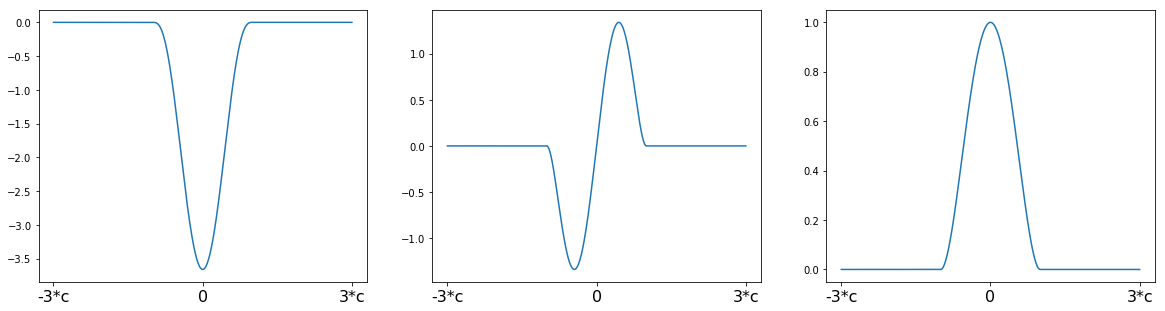

In [199]:
# Plot method can be found http://www.statsmodels.org/devel/examples/notebooks/generated/robust_models_1.html
def plot_weights(support, weights_func, xlabels, xticks,sub,fig):
    
    ax = fig.add_subplot(sub)
    ax.plot(support, weights_func(support))
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, fontsize=16)
    #ax.set_ylim(-.1, 1.1)
    return ax


c = 4.685
support = np.linspace(-3*c, 3*c, 1000)
tukey = TukeyBiweight(c=c)

fig = plt.figure(figsize=(20,5))
plot_weights(support, tukey.rho, ['-3*c', '0', '3*c'], [-3*c, 0, 3*c],131,fig);
plot_weights(support, tukey.psi, ['-3*c', '0', '3*c'], [-3*c, 0, 3*c],132,fig);
plot_weights(support, tukey.weights, ['-3*c', '0', '3*c'], [-3*c, 0, 3*c],133,fig);

In [181]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


In [264]:
# define the Michaelis–Menten model for enzyme kinetics has two parameters and one independent variable, related by f 
# as callable fun 
# x0 Vmax
# x1 Km
def fun(x, t, y):
    return x[0] *np.asarray(t)/ (x[1] + np.asarray(t)) - y

## M-Estimator
### Define function of the weight psi/z
### Solve the equation of least square
### Guess the weights, W0, fit to get B0 , then calculate Residual, use those residuals to calculate new weights, in M-estimator, the new weight = psi/r. Then re-fit to get B1, repeat until B converge.


def IRLS(y, X, maxiter, w_init=1, d=0.0001, tolerance=0.001):
    n, p = X.shape
    # 生成数组，其中repeat函数生成n个d，reshape函数将一维数组变成二维数组，
    # 一行n列的数组
    delta = array(repeat(d, n)).reshape(1, n)
    # w是n个1的数组
    w = repeat(1, n)
    # W是对角线上为w的对角矩阵
    W = diag(w)
    z = inv(W).dot(y)
    B = dot(inv(X.T.dot(W).dot(X)),
            (X.T.dot(W).dot(z)))
    for _ in range(maxiter):
        _B = B
        _w = abs(y - X.dot(B)).T
        # w = float(1) / maximum(delta, _w)
        tmpx = X.dot(B)

        tmpxx = tmpx * (1 - tmpx)
        tmpxxx = tmpxx.reshape(1, 99)
        W = diag(tmpxxx[0])
        z = X.dot(B) - inv(W).dot(X.dot(B) - y)
        B = dot(inv(X.T.dot(W).dot(X)),
                (X.T.dot(W).dot(z)))
        tol = sum(abs(B - _B))
        print("Tolerance = %s" % tol)
        if tol < tolerance:
            return B
    return B

In [265]:
# Generate noised function data with possible outliers
def generate_data(t, Vmax, Km, noise=0, n_outliers=0, random_state=0):
    y = Vmax * t / (Km + t)
    rnd = np.random.RandomState(random_state)
    error = noise * rnd.randn(t.size)
    outliers = rnd.randint(0, t.size, n_outliers)
    error[outliers] *= 10
    return y + error



In [266]:
# Generate noised dataset from given parameters
Vmax = 0.362
Km = 0.556
x_true = np.array([Vmax, Km])


# Input your trainning dataset

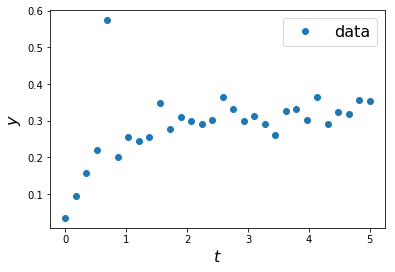

In [305]:
# Generated dataset with noise and outliers 
# Can be replaced by User's own dataset
noise = 0.02
t_min = 0
t_max = 5
t_train = np.linspace(t_min, t_max, 30)
y_train = generate_data(t_train, Vmax,Km, noise=noise, n_outliers=3)
plt.plot(t_train, y_train, 'o', label='data')
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.legend();

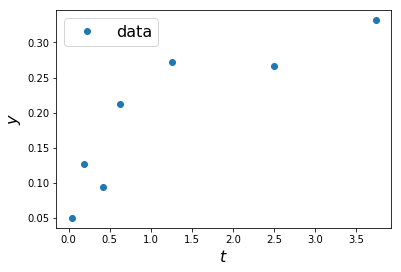

In [279]:
# Another dataset from wiki
Vmax = 0.362
Km = 0.556
x_true = np.array([Vmax, Km])

t_train = [0.038,0.194,0.425,0.626,1.253,2.500,3.740]
y_train = [0.050,0.127,0.094,0.2122,0.2729,0.2665,0.3317]
plt.plot(t_train, y_train, 'o', label='data')
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.legend();

In [306]:
# initial value is very important
import numpy as np
x0 = np.ones(2)
x0 = np.array([0.5,0.5])


In [307]:
from scipy.optimize import least_squares

In [308]:
res_lsq = least_squares(fun, x0, args=(t_train, y_train))
# set initialised x0 by least square
x0 = res_lsq.x
print x0

[0.34143418 0.21639553]


In [312]:
res_robust = least_squares(fun, x0, loss=tB.loss, f_scale=0.01, args=(t_train, y_train))
print res_robust.x

[0.3560028 0.4694951]


In [313]:
# y_test y of ground truth curve
t_test = np.linspace(t_min, t_max, 300)
y_test = generate_data(t_test, Vmax, Km)

# y_lsq : fitted y value from method of least square, 
# y_robust : fitted y value from method of robust regression
# robust regression weight can be defined with l1 soft or Huber T or callable fun

y_lsq = generate_data(t_test, *res_lsq.x)
y_robust = generate_data(t_test, *res_robust.x)

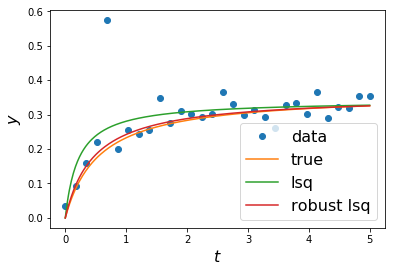

In [314]:
# Compare diffrent method 
plt.plot(t_train, y_train, 'o', label='data')
plt.plot(t_test, y_test, label='true')
plt.plot(t_test, y_lsq, label='lsq')
plt.plot(t_test, y_robust, label='robust lsq')
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.legend();

In [315]:
print res_lsq.x
print res_robust.x
print x_true

[0.34143418 0.21639553]
[0.3560028 0.4694951]
[0.362 0.556]
